In [1]:
from tqdm import tqdm_notebook, tqdm

In [2]:
import numpy as np
import pandas as pd
%matplotlib inline
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
columns = ('appId', 'name')
df_games_names = pd.concat([pd.read_csv('../csv/page{}_games.csv'.format(i), usecols=[1, 2], names=columns) for i in range(1, 6)])

df_games_names

,appId,name
0,271590,Grand Theft Auto V
1,1174180,Red Dead Redemption 2
2,1145360,Hades
3,715950,Divinity: Original Sin 2
4,391540,Undertale
...,...,...
11,1237970,Titanfall 2
12,584400,Sonic Mania
13,268500,XCOM 2
14,412830,STEINS;GATE


In [4]:
columns = ('appId', 'user', 'rating', 'hours')
df_reviews = pd.concat([pd.read_csv('../csv/page{}_reviews.csv'.format(i), usecols=[0, 3, 6, 7], names=columns) for i in range(1,6)], ignore_index=True)
df_reviews

,appId,user,rating,hours
0,1145360,76561198059680994,1,48.3
1,1145360,lalaso123,1,23.2
2,1145360,76561198008088676,1,5.1
3,1145360,YogurtRed,1,11.4
4,1145360,76561199095470163,1,22.8
...,...,...,...,...
976869,809230,7.65612E+16,1,41.6
976870,809230,7.65612E+16,1,63.6
976871,809230,7.65612E+16,1,19.1
976872,809230,7.65612E+16,1,136.6


In [5]:
df_sentiments = pd.read_csv('../csv/sentiment.csv', names=['appId', 'user','sentiment'])
df_sentiments

C:\Users\ddamddi\Anaconda3\envs\steam_crawler\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (1,3) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,appId,user,sentiment
NaN,appId,user,sentiment
0.0,1145360,76561198059680994,0.4927
1.0,1145360,lalaso123,0.7857
2.0,1145360,76561198008088676,0.9799
3.0,1145360,YogurtRed,0.5563
...,...,...,...
976869.0,809230,7.65612E+16,0.5267
976870.0,809230,7.65612E+16,-0.5423
976871.0,809230,7.65612E+16,0
976872.0,809230,7.65612E+16,0.4118


In [6]:
df_sentiments

,appId,user,sentiment
NaN,appId,user,sentiment
0.0,1145360,76561198059680994,0.4927
1.0,1145360,lalaso123,0.7857
2.0,1145360,76561198008088676,0.9799
3.0,1145360,YogurtRed,0.5563
...,...,...,...
976869.0,809230,7.65612E+16,0.5267
976870.0,809230,7.65612E+16,-0.5423
976871.0,809230,7.65612E+16,0
976872.0,809230,7.65612E+16,0.4118


In [7]:
def normalize(score):
    """
    Normalize the score to be between -1 and 1 using an alpha that
    approximates the max expected value
    """
    score = float(score)
    norm_score = (score+1.0)/0.4
    return norm_score

In [8]:
df_sentiments['sentiment']

NaN         sentiment
0.0            0.4927
1.0            0.7857
2.0            0.9799
3.0            0.5563
              ...    
976869.0       0.5267
976870.0      -0.5423
976871.0            0
976872.0       0.4118
976873.0       0.2023
Name: sentiment, Length: 976875, dtype: object

In [9]:
norm_score = list()
for idx, score in enumerate(df_sentiments['sentiment']):
    if idx == 0:
        continue
#     print(normalize(score))
    norm_score.append(normalize(score))

In [10]:
len(norm_score)

976874

In [11]:
df_reviews

,appId,user,rating,hours
0,1145360,76561198059680994,1,48.3
1,1145360,lalaso123,1,23.2
2,1145360,76561198008088676,1,5.1
3,1145360,YogurtRed,1,11.4
4,1145360,76561199095470163,1,22.8
...,...,...,...,...
976869,809230,7.65612E+16,1,41.6
976870,809230,7.65612E+16,1,63.6
976871,809230,7.65612E+16,1,19.1
976872,809230,7.65612E+16,1,136.6


In [12]:
df_reviews['sentiment'] = norm_score
df_reviews

,appId,user,rating,hours,sentiment
0,1145360,76561198059680994,1,48.3,3.73175
1,1145360,lalaso123,1,23.2,4.46425
2,1145360,76561198008088676,1,5.1,4.94975
3,1145360,YogurtRed,1,11.4,3.89075
4,1145360,76561199095470163,1,22.8,4.80900
...,...,...,...,...,...
976869,809230,7.65612E+16,1,41.6,3.81675
976870,809230,7.65612E+16,1,63.6,1.14425
976871,809230,7.65612E+16,1,19.1,2.50000
976872,809230,7.65612E+16,1,136.6,3.52950


In [13]:
indexNames = df_reviews[df_reviews['user'] == '#NAME?' ].index
df_reviews.drop(indexNames , inplace=True)
df_unique_reivews = df_reviews.drop_duplicates(subset=['appId', 'user'])
df_unique_reivews.shape

(877415, 5)

In [14]:
g = df_unique_reivews.groupby('user').agg('count')
df_unique_reivews_filtered = g[g['rating'] >= 3]

In [15]:
df_unique_reivews_filtered

,appId,rating,hours,sentiment
user,,,,
----Werewolf---,3,3,3,3
--infinite,3,3,3,3
-5k,3,3,3,3
-D14b0lIc5a1b0tD47k9t0p1ak54n-,4,4,4,4
-Fanta,3,3,3,3
...,...,...,...,...
zyrkan,8,8,8,8
zyrums,5,5,5,5
zzfuzzy,5,5,5,5


In [16]:
selected_users = df_unique_reivews_filtered.index.tolist()

In [17]:
selected_reviews = pd.DataFrame(columns = ['appId', 'user', 'rating', 'hours', 'sentiment'])

In [18]:
selected_reviews = df_unique_reivews.loc[df_unique_reivews['user'].isin(selected_users)]

In [19]:
selected_reviews

,appId,user,rating,hours,sentiment
2,1145360,76561198008088676,1,5.1,4.94975
10,1145360,76561198129497218,1,4.7,4.51400
12,1145360,Yenna1173,1,18.8,3.05400
14,1145360,76561197965361589,1,22.4,3.79675
15,1145360,gpzzz,1,4.5,4.56775
...,...,...,...,...,...
976738,809230,cbi1264,1,3.4,4.88725
976775,809230,FippeFi,1,14.7,4.77025
976779,809230,6ap6apblckaAa,1,124.1,4.44450
976842,809230,milkmouf,-1,0.9,2.24325


In [20]:
selected_reviews.sort_values(['user'])

,appId,user,rating,hours,sentiment
757305,976310,----Werewolf---,1,7.4,4.81425
911313,377160,----Werewolf---,1,69.8,4.92050
491402,519860,----Werewolf---,1,1.9,4.49100
565888,582010,--infinite,-1,4.4,1.14425
686792,501300,--infinite,1,1.8,3.35000
...,...,...,...,...,...
161189,524220,zzzzzzzzzx_x,1,76.5,3.60100
48992,287700,zzzzzzzzzx_x,1,267.0,2.88275
249783,261570,zzzzzzzzzzz111,1,17.1,4.06225
914593,377160,zzzzzzzzzzz111,1,162.3,3.64700


In [21]:
df_games_users = selected_reviews.pivot_table(
    index='user',
    columns='appId',
    values='sentiment'
).fillna(float('nan'))
# ).fillna(2.5)

df_games_users

appId,570,107100,115800,200900,224760,231200,236430,242550,247080,250700,...,1080110,1118010,1145360,1158310,1174180,1222690,1237970,1238840,1250410,1295510
user,,,,,,,,,,,,,,,,,,,,,
----Werewolf---,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
--infinite,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-5k,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.46725,NaN,NaN,NaN
-D14b0lIc5a1b0tD47k9t0p1ak54n-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.91675,NaN,NaN
-Fanta,NaN,NaN,NaN,2.5,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zyrkan,NaN,NaN,NaN,NaN,4.36975,1.56075,NaN,NaN,4.567,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
zyrums,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
zzfuzzy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
df_games_users

appId,570,107100,115800,200900,224760,231200,236430,242550,247080,250700,...,1080110,1118010,1145360,1158310,1174180,1222690,1237970,1238840,1250410,1295510
user,,,,,,,,,,,,,,,,,,,,,
----Werewolf---,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
--infinite,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-5k,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.46725,NaN,NaN,NaN
-D14b0lIc5a1b0tD47k9t0p1ak54n-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.91675,NaN,NaN
-Fanta,NaN,NaN,NaN,2.5,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zyrkan,NaN,NaN,NaN,NaN,4.36975,1.56075,NaN,NaN,4.567,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
zyrums,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
zzfuzzy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
df_games_users_train, df_games_users_test = train_test_split(df_games_users, test_size=(1000/23556))

In [24]:
df_games_users_train = df_games_users_train.fillna(2.5)
df_games_users_train

appId,570,107100,115800,200900,224760,231200,236430,242550,247080,250700,...,1080110,1118010,1145360,1158310,1174180,1222690,1237970,1238840,1250410,1295510
user,,,,,,,,,,,,,,,,,,,,,
jmhj,2.5,2.50000,2.50000,2.569,2.50000,2.5,2.5,2.5,3.403,2.5,...,2.5,2.50000,2.5,2.5,2.5,2.5,2.50000,2.5,2.5,2.5
N3aera,2.5,2.50000,2.50000,2.500,2.50000,2.5,2.5,2.5,2.500,2.5,...,2.5,2.50000,2.5,2.5,2.5,2.5,4.46125,2.5,2.5,2.5
WontonWombat,2.5,2.50000,2.50000,2.500,2.50000,2.5,2.5,2.5,2.500,2.5,...,2.5,2.50000,2.5,2.5,2.5,2.5,2.50000,2.5,2.5,2.5
VanDarkStrom,2.5,2.50000,2.50000,2.500,2.50000,2.5,2.5,2.5,2.500,2.5,...,2.5,2.50000,2.5,2.5,2.5,2.5,2.50000,2.5,2.5,2.5
eroticpotato,2.5,2.50000,2.50000,2.500,2.50000,2.5,2.5,2.5,2.500,2.5,...,2.5,2.50000,2.5,2.5,2.5,2.5,2.50000,2.5,2.5,2.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
aelfrey,2.5,2.50000,2.50000,2.500,3.55375,2.5,2.5,2.5,2.500,2.5,...,2.5,2.50000,2.5,2.5,2.5,2.5,2.50000,2.5,2.5,2.5
goodguyliam,2.5,2.50000,2.50000,2.500,2.50000,2.5,2.5,2.5,2.500,2.5,...,2.5,0.90075,2.5,2.5,2.5,2.5,2.50000,2.5,2.5,2.5
CortanaDoomGuy,2.5,3.21075,0.01725,2.500,2.50000,2.5,2.5,2.5,2.500,2.5,...,2.5,2.50000,2.5,2.5,2.5,2.5,2.50000,2.5,2.5,2.5


In [25]:
df_games_users_test

appId,570,107100,115800,200900,224760,231200,236430,242550,247080,250700,...,1080110,1118010,1145360,1158310,1174180,1222690,1237970,1238840,1250410,1295510
user,,,,,,,,,,,,,,,,,,,,,
El_Rey_De_Los_Piratas,NaN,NaN,NaN,NaN,3.89075,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
76561198051397823,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MoeJoeGames,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
76561198007674930,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Toaster-chan,NaN,NaN,NaN,NaN,2.50000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76561198027103160,NaN,NaN,NaN,NaN,NaN,4.96475,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
76561198210382241,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pvengeance,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,3.98175,NaN,NaN,NaN,NaN,NaN


In [26]:
bmask = df_games_users_test.where(df_games_users_test >= 0, other=-1)
bmask = bmask.where(bmask < 0, other=True)
bmask = bmask.where(bmask >= 0, other=False)
bmask

appId,570,107100,115800,200900,224760,231200,236430,242550,247080,250700,...,1080110,1118010,1145360,1158310,1174180,1222690,1237970,1238840,1250410,1295510
user,,,,,,,,,,,,,,,,,,,,,
El_Rey_De_Los_Piratas,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
76561198051397823,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
MoeJoeGames,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
76561198007674930,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Toaster-chan,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76561198027103160,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
76561198210382241,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
pvengeance,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False


In [27]:
import random

def condition(x): return x == True

def create_labels(df, mask):
    review_index = []
    labels = []

    for i in tqdm_notebook(range(len(df))):
        tmp = mask.iloc[i].to_list()
        index = [idx for idx, element in enumerate(tmp) if condition(element)]
        review_index.append(index)
    
    for i in tqdm_notebook(range(len(df))):
        
        choice = random.choice(review_index[i])
#         print(review_index[i])
        review_index[i].remove(choice)
#         print(choice)
#         print(review_index[i])
#         print()
        
        labels.append([choice])
#         print(df.iloc[i, choice])
        df.iloc[i, choice] = float('nan')
#         print(df.iloc[i, choice])
    
    
    return labels, df, review_index

test_label, test_df, test_review_index = create_labels(df_games_users_test, bmask)

# print()
# print(test_review_index[0])

# print(test_label[0])
# print()

<ipython-input-27-8ccfa77836e8>:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(len(df))):


<ipython-input-27-8ccfa77836e8>:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(len(df))):


C:\Users\ddamddi\Anaconda3\envs\steam_crawler\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-27-8ccfa77836e8>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.iloc[i, choice] = float('nan')


In [28]:
test_df = test_df.fillna(2.5)

In [29]:
df_games_users_train.values.shape

(22556, 81)

In [30]:
df_games_users_train = df_games_users_train.astype('float')

In [31]:
df_games_users_train

appId,570,107100,115800,200900,224760,231200,236430,242550,247080,250700,...,1080110,1118010,1145360,1158310,1174180,1222690,1237970,1238840,1250410,1295510
user,,,,,,,,,,,,,,,,,,,,,
jmhj,2.5,2.50000,2.50000,2.569,2.50000,2.5,2.5,2.5,3.403,2.5,...,2.5,2.50000,2.5,2.5,2.5,2.5,2.50000,2.5,2.5,2.5
N3aera,2.5,2.50000,2.50000,2.500,2.50000,2.5,2.5,2.5,2.500,2.5,...,2.5,2.50000,2.5,2.5,2.5,2.5,4.46125,2.5,2.5,2.5
WontonWombat,2.5,2.50000,2.50000,2.500,2.50000,2.5,2.5,2.5,2.500,2.5,...,2.5,2.50000,2.5,2.5,2.5,2.5,2.50000,2.5,2.5,2.5
VanDarkStrom,2.5,2.50000,2.50000,2.500,2.50000,2.5,2.5,2.5,2.500,2.5,...,2.5,2.50000,2.5,2.5,2.5,2.5,2.50000,2.5,2.5,2.5
eroticpotato,2.5,2.50000,2.50000,2.500,2.50000,2.5,2.5,2.5,2.500,2.5,...,2.5,2.50000,2.5,2.5,2.5,2.5,2.50000,2.5,2.5,2.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
aelfrey,2.5,2.50000,2.50000,2.500,3.55375,2.5,2.5,2.5,2.500,2.5,...,2.5,2.50000,2.5,2.5,2.5,2.5,2.50000,2.5,2.5,2.5
goodguyliam,2.5,2.50000,2.50000,2.500,2.50000,2.5,2.5,2.5,2.500,2.5,...,2.5,0.90075,2.5,2.5,2.5,2.5,2.50000,2.5,2.5,2.5
CortanaDoomGuy,2.5,3.21075,0.01725,2.500,2.50000,2.5,2.5,2.5,2.500,2.5,...,2.5,2.50000,2.5,2.5,2.5,2.5,2.50000,2.5,2.5,2.5


In [32]:
df_games_users_test

appId,570,107100,115800,200900,224760,231200,236430,242550,247080,250700,...,1080110,1118010,1145360,1158310,1174180,1222690,1237970,1238840,1250410,1295510
user,,,,,,,,,,,,,,,,,,,,,
El_Rey_De_Los_Piratas,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
76561198051397823,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MoeJoeGames,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
76561198007674930,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Toaster-chan,NaN,NaN,NaN,NaN,2.5,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76561198027103160,NaN,NaN,NaN,NaN,NaN,4.96475,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
76561198210382241,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pvengeance,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
from scipy.sparse import csr_matrix

sparse_mat_games_users = csr_matrix(df_games_users_train.values)
sparse_mat_games_users_test = csr_matrix(test_df.values)

In [34]:
sparse_mat_games_users_test

<1000x81 sparse matrix of type '<class 'numpy.float64'>'
	with 81000 stored elements in Compressed Sparse Row format>

In [35]:
from sklearn.neighbors import NearestNeighbors

model = NearestNeighbors(metric='cosine', n_neighbors=100, n_jobs=-1)

model.fit(sparse_mat_games_users)

NearestNeighbors(metric='cosine', n_jobs=-1, n_neighbors=100)

In [36]:
distances, indices = model.kneighbors(
            sparse_mat_games_users_test[10],
            n_neighbors=10+1)

In [37]:
indices

array([[15972,  5897, 18165, 20378, 17587,  8666,  7275,    36, 12691,
         5826, 17912]], dtype=int64)

In [38]:
distances

array([[1.58076299e-05, 2.03817982e-05, 2.28304019e-05, 2.28304019e-05,
        2.28304019e-05, 2.28304019e-05, 3.35504002e-05, 3.95120337e-05,
        4.03357209e-05, 4.66652504e-05, 5.69831102e-05]])

In [39]:
def get_distance(indices, distances):
    raw_recommends = \
                sorted(
                    list(
                        zip(
                            indices.squeeze().tolist(),
                            distances.squeeze().tolist()
                        )
                    ),
                    key=lambda x: x[1]
                )[1:]

    return raw_recommends

In [40]:
sparse_mat_games_users_test

<1000x81 sparse matrix of type '<class 'numpy.float64'>'
	with 81000 stored elements in Compressed Sparse Row format>

In [41]:
result = []

for i in tqdm_notebook(range(len(df_games_users_test))):
    distances, indices = model.kneighbors(sparse_mat_games_users_test[i], n_neighbors=100)
    result.append(get_distance(distances, indices))

<ipython-input-41-cf97b274fd3b>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(len(df_games_users_test))):


In [42]:
df_games_users_test

appId,570,107100,115800,200900,224760,231200,236430,242550,247080,250700,...,1080110,1118010,1145360,1158310,1174180,1222690,1237970,1238840,1250410,1295510
user,,,,,,,,,,,,,,,,,,,,,
El_Rey_De_Los_Piratas,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
76561198051397823,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MoeJoeGames,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
76561198007674930,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Toaster-chan,NaN,NaN,NaN,NaN,2.5,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76561198027103160,NaN,NaN,NaN,NaN,NaN,4.96475,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
76561198210382241,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pvengeance,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [67]:
import numpy as np
from collections import Counter
K = 10
N = 1

count_list = []

def get_accuracy(result, test_label, test_review_index):
    correct = 0
    for i in tqdm_notebook(range(len(result))):
        counter = 0
        sum_x = None
        for j in sorted(result[i]):
            if counter == K:
                break
            
            x = (df_games_users_train.iloc[j[1]] - 2.5).to_list()        
            
            if counter == 0:
                sum_x = (np.asarray(x) * (K-counter))
            else:
                sum_x += (np.asarray(x)  * (K-counter))
            counter += 1
        
        for idx in test_review_index[i]:
            sum_x[idx] = -2.5
        
        args = []
        for _ in range(N):
            args.append(np.argmax(sum_x))
            sum_x[np.argmax(sum_x)] = -2.5
        
        if test_label[i][0] in args:
            correct += 1
        
        count_list.append(args[0])
        
        
    return correct / len(test_label) * 100
        
get_accuracy(result, test_label, test_review_index)
print(Counter(count_list))

<ipython-input-67-e5b0cf422f59>:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(len(result))):



Counter({0: 186, 29: 63, 38: 56, 21: 51, 11: 41, 48: 41, 27: 40, 30: 37, 63: 36, 65: 30, 15: 28, 44: 26, 19: 23, 58: 21, 6: 17, 74: 17, 50: 16, 56: 16, 69: 14, 61: 13, 18: 13, 75: 12, 43: 12, 23: 12, 59: 10, 41: 9, 55: 9, 14: 8, 77: 8, 13: 8, 2: 7, 20: 7, 39: 7, 10: 7, 40: 6, 52: 6, 53: 6, 8: 6, 72: 6, 42: 6, 1: 5, 16: 5, 5: 5, 34: 4, 4: 4, 66: 4, 25: 4, 28: 3, 73: 3, 37: 3, 7: 2, 76: 2, 35: 2, 31: 2, 79: 2, 33: 2, 51: 1, 24: 1, 32: 1, 47: 1, 49: 1, 67: 1, 46: 1, 17: 1, 78: 1, 45: 1, 26: 1})


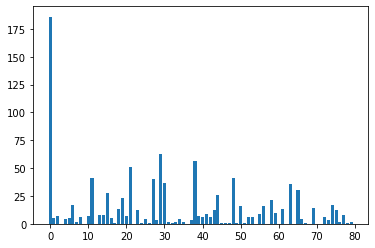

In [69]:
from matplotlib import pyplot as plt

c = Counter(count_list)

plt.bar(c.keys(), c.values())
plt.show()

[[4],
 [59],
 [21],
 [55],
 [29],
 [29],
 [29],
 [58],
 [10],
 [21],
 [52],
 [27],
 [48],
 [58],
 [16],
 [10],
 [44],
 [63],
 [21],
 [19],
 [75],
 [29],
 [63],
 [27],
 [29],
 [18],
 [71],
 [6],
 [19],
 [50],
 [40],
 [48],
 [75],
 [38],
 [56],
 [19],
 [59],
 [55],
 [1],
 [43],
 [38],
 [29],
 [20],
 [19],
 [65],
 [30],
 [21],
 [14],
 [38],
 [39],
 [1],
 [48],
 [65],
 [69],
 [1],
 [44],
 [21],
 [24],
 [72],
 [75],
 [65],
 [38],
 [77],
 [43],
 [14],
 [48],
 [40],
 [11],
 [34],
 [13],
 [38],
 [10],
 [23],
 [27],
 [29],
 [65],
 [63],
 [1],
 [29],
 [63],
 [25],
 [11],
 [59],
 [56],
 [18],
 [55],
 [30],
 [43],
 [59],
 [27],
 [38],
 [27],
 [44],
 [21],
 [56],
 [38],
 [29],
 [18],
 [27],
 [29],
 [21],
 [57],
 [66],
 [50],
 [44],
 [15],
 [65],
 [29],
 [50],
 [38],
 [48],
 [24],
 [55],
 [61],
 [50],
 [18],
 [12],
 [24],
 [38],
 [65],
 [48],
 [39],
 [61],
 [50],
 [1],
 [31],
 [25],
 [50],
 [16],
 [47],
 [31],
 [30],
 [29],
 [63],
 [13],
 [35],
 [74],
 [44],
 [77],
 [65],
 [21],
 [44],
 [63],
 [29],

In [61]:
test_df

appId,570,107100,115800,200900,224760,231200,236430,242550,247080,250700,...,1080110,1118010,1145360,1158310,1174180,1222690,1237970,1238840,1250410,1295510
user,,,,,,,,,,,,,,,,,,,,,
El_Rey_De_Los_Piratas,2.5,2.5,2.5,2.5,2.5,2.50000,2.5,2.5,2.5,2.5,...,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5
76561198051397823,2.5,2.5,2.5,2.5,2.5,2.50000,2.5,2.5,2.5,2.5,...,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5
MoeJoeGames,2.5,2.5,2.5,2.5,2.5,2.50000,2.5,2.5,2.5,2.5,...,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5
76561198007674930,2.5,2.5,2.5,2.5,2.5,2.50000,2.5,2.5,2.5,2.5,...,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5
Toaster-chan,2.5,2.5,2.5,2.5,2.5,2.50000,2.5,2.5,2.5,2.5,...,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76561198027103160,2.5,2.5,2.5,2.5,2.5,4.96475,2.5,2.5,2.5,2.5,...,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5
76561198210382241,2.5,2.5,2.5,2.5,2.5,2.50000,2.5,2.5,2.5,2.5,...,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5
pvengeance,2.5,2.5,2.5,2.5,2.5,2.50000,2.5,2.5,2.5,2.5,...,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5


In [63]:
df_games_names['appId'] == 0

0     False
1     False
2     False
3     False
4     False
      ...  
11    False
12    False
13    False
14    False
15    False
Name: appId, Length: 82, dtype: bool